### This code analyzes the sideline accuracy of individual players, identifying whether a player was able to keep his sideline shots inbounds or not during the 2015 US Open.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from math import*
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pyodbc

In [3]:
# storing variables we will need for the rest of the code
Xmid = 11.887
Ymid = 4.115
X = 11.887 + .0265 # taking into account the width of the line for both X and Y
Y = 4.115 + .0265
serviceline = 6.401
farline = 1.3716
Xincr = 1
Yincr = 2

# how far in and out of the sidelines we will consider sideline shots
inline = 1
outline = 1

In [4]:
# functions we will use in the rest of the code

def CourtLines(X=X,Y=Y,Xmid=Xmid,Ymid=Ymid,serline=serviceline,alph=1,col='w'):
   
    x2 = np.linspace(0,serviceline,100) # mid line
    y2 = np.linspace(0,0,100)
    plt.plot(x2,y2,color=col,lw=3,alpha=alph)

    x3 = np.linspace(0,Xmid,100) # positive sideline
    y3 = np.linspace(Ymid,Ymid,100)
    plt.plot(x3,y3,color=col,lw=3,alpha=alph)

    x4 = np.linspace(0,Xmid,100) # negative sideline
    y4 = np.linspace(-Ymid,-Ymid,100)
    plt.plot(x4,y4,color=col,lw=3,alpha=alph)

    x5 = np.linspace(Xmid,Xmid,100) # baseline
    y5 = np.linspace(-Ymid-1.3716,Ymid+1.3716,100)
    plt.plot(x5,y5,color=col,lw=3,alpha=alph)

    x6 = np.linspace(0,Xmid,100) # far positive sideline
    y6 = np.linspace(Ymid+1.3716,Ymid+1.3716,100)
    plt.plot(x6,y6,color=col,lw=3,alpha=alph)

    x7 = np.linspace(0,Xmid,100) # far negative sideline
    y7 = np.linspace(-Ymid-1.3716,-Ymid-1.3716,100)
    plt.plot(x7,y7,color=col,lw=3,alpha=alph)

    x1 = np.linspace(serviceline,serviceline,100) # service line
    y1 = np.linspace(-Ymid,Ymid,100)
    plt.plot(x1,y1,color=col,lw=3,alpha=alph)

def CourtSurf(X=X,Y=Y,Xincr=Xincr,Yincr=Yincr,farline=farline,court='#2A5387',outofbound='#658B4E'):
    
    # gray out of bounds
    rectangle2 = plt.Rectangle((0,-Y-Yincr),X,Yincr,fc=outofbound,ec='none')
    plt.gca().add_patch(rectangle2)

    rectangle3 = plt.Rectangle((0,Y),X,Yincr,fc=outofbound,ec='none')
    plt.gca().add_patch(rectangle3)

    rectangle4 = plt.Rectangle((X,-Y-Yincr),Xincr,2*Y+2*Yincr,fc=outofbound,ec='none')
    plt.gca().add_patch(rectangle4)

    # navy backdrop 
    rectangle1 = plt.Rectangle((0,-Y-farline),X,2*Y+2*1.3716,fc=court,ec='none')
    plt.gca().add_patch(rectangle1)

In [4]:
cnxn = pyodbc.connect(r'Driver={SQL Server};Server=EC2DSTGDB15\SQL2K14GENERAL;Database=HawkEye;Trusted_Connection=yes;')

    
with open("AllBouncesCF.sql", "r") as myfile:
    sql3 = myfile.read()
    
AllHits = pd.read_sql(sql3,cnxn)
AllHits = AllHits[abs(AllHits['X']) <= X]
AllHits = AllHits.reset_index(drop=True)

### The cell below analyzes sideline accuracy of each player for every match.

In [5]:
# analyzing sideline accuracy per match

LastHit = AllHits[AllHits['LastShot'] == 1]; LastHit = LastHit.reset_index(drop=True)
players = AllHits.playerName.unique(); players.sort()
npl = len(players)

Match = []; Opp = []; SideAcc = []; RSideAcc = []; LSideAcc = []; PLYR = []; Tot = []
TotShotsSidePct = []; TotalShots = []

for i in range(npl):
    
    df = AllHits[AllHits['playerName'] == players[i]]; df = df.reset_index(drop=True)
    matches = df['matchCode'].unique()
    m = len(matches)
    
    for j in range(m):
        
        plyrs = AllHits['playerName'][AllHits['matchCode'] == matches[j]].unique()
        opp = plyrs[plyrs != players[i]][0]
        
        MatchLH = LastHit[LastHit['matchCode'] == matches[j]]
        MatchLH = MatchLH[MatchLH['playerName'] == players[i]]

        WLH = MatchLH[MatchLH['WonPoint'] == 1]
        WLH = WLH[abs(WLH['Y']) <= Y]
        WLH = WLH.reset_index(drop=True)
        xWLH = WLH['X']; yWLH = WLH['Y']

        LLH = MatchLH[MatchLH['WonPoint'] == 0]
        LLH = LLH[abs(LLH['Y']) > Y]
        LLH = LLH[abs(LLH['Y']) <= Y + outline]
        LLH = LLH.reset_index(drop=True)
        xLLH = LLH['X']; yLLH = LLH['Y']

        OH = df[df['matchCode'] == matches[j]]
        OH = OH[OH['LastShot'] == 0]
        OH = OH[abs(OH['Y']) <= Y]
        OH = OH.reset_index(drop=True)
        xOH = OH['X']; yOH = OH['Y']

        othside = len(yOH[abs(yOH) >= Y-inline]); roth = len(yOH[yOH < -Y+inline]); loth = len(yOH[yOH > Y-inline])
        sidewin = len(yWLH[abs(yWLH) >= Y-inline]); rsidewin = len(yWLH[yWLH < -Y+inline]); lsidewin = len(yWLH[yWLH > Y-inline])
        midwin = len(yWLH[abs(yWLH) < Y-inline])
        nearmiss = len(yLLH); rnearmiss = len(yLLH[yLLH < 0]); lnearmiss = len(yLLH[yLLH > 0]) 
        Totshots = len(xOH) + len(xWLH) + nearmiss
        
        SideAcc.append(round((othside+sidewin)/float(sidewin+nearmiss+othside),4))
        RSideAcc.append(round((roth+rsidewin)/float(rsidewin+rnearmiss+roth),4))
        LSideAcc.append(round((loth+lsidewin)/float(lsidewin+lnearmiss+loth),4))
        PLYR.append(players[i])
        Match.append(matches[j])
        Opp.append(opp) 
        Tot.append(sidewin+nearmiss+othside)
        TotalShots.append(Totshots)
        TotShotsSidePct.append(round((nearmiss+sidewin+othside)/float(Totshots),4))

SideAccMatch = pd.DataFrame()
SideAccMatch['MatchCode'] = Match
SideAccMatch['Player'] = PLYR
SideAccMatch['Opponent'] = Opp
SideAccMatch['TotSideShots'] = Tot
SideAccMatch['SidelineAcc'] = SideAcc
SideAccMatch['TotShotswithinBound'] = TotalShots
SideAccMatch['TotShotsSidePct'] = TotShotsSidePct
SideAccMatch['LSideAcc'] = LSideAcc
SideAccMatch['RSideAcc'] = RSideAcc
SideAccMatch['SideAccDiff'] = abs(np.array(LSideAcc)-np.array(RSideAcc))

In [6]:
df = SideAccMatch[SideAccMatch['TotSideShots'] >= 50] 
df.sort_values(by='SidelineAcc',ascending=0).head(10)

,MatchCode,Player,Opponent,TotSideShots,SidelineAcc,TotShotswithinBound,TotShotsSidePct,LSideAcc,RSideAcc,SideAccDiff
68,MS302,GOFFIN,BAUTISTA AGUT,76,0.9605,277,0.2744,0.9412,0.9762,0.0350
107,MS133,RAMOS-VINOLAS,WAWRINKA,54,0.9444,293,0.1843,0.9545,0.9375,0.0170
52,MS216,FERRER,KRAJINOVIC,64,0.9375,300,0.2133,0.8519,1.0000,0.1481
103,MS305,PAIRE,ROBREDO,64,0.9375,260,0.2462,0.9259,0.9459,0.0200
32,MS401,DJOKOVIC,BAUTISTA AGUT,103,0.9320,568,0.1813,0.9348,0.9298,0.0050
61,MS226,GARCIA-LOPEZ,MAHUT,73,0.9315,340,0.2147,0.8421,0.9630,0.1209
94,MS148,MURRAY,KYRGIOS,51,0.9216,348,0.1466,0.9130,0.9286,0.0156
74,MS227,HEWITT,TOMIC,87,0.9195,513,0.1696,0.8611,0.9608,0.0997
141,MS310,YOUNG,TROICKI,97,0.9175,555,0.1748,0.9091,0.9286,0.0195
2,MS406,ANDERSON,MURRAY,84,0.9167,400,0.2100,0.9333,0.9074,0.0259


### The cell below analyzes the sideline accuracy of each individual player and all of his shots during the 2015 US Open.

In [7]:
# analyzing sideline accuracy by total shots per player
LastHit = AllHits[AllHits['LastShot'] == 1]; LastHit = LastHit.reset_index(drop=True)
p = AllHits.playerName.unique(); p.sort()
npl = len(p)

SideAcc = []; RSideAcc = []; LSideAcc = []; PLYR = []; Tot = []
TotShotsSidePct = []; TotalShots = []

for i in range(npl):
    
    AH = AllHits[AllHits['playerName'] == p[i]]
    LH = LastHit[LastHit['playerName'] == p[i]]

    WLH = LH[LH['WonPoint'] == 1]
    WLH = WLH[abs(WLH['Y']) <= Y]
    xWLH = WLH['X']; yWLH = WLH['Y']

    LLH = LH[LH['WonPoint'] == 0]
    LLH = LLH[abs(LLH['Y']) > Y]
    LLH = LLH[abs(LLH['Y']) <= Y + outline]
    xLLH = LLH['X']; yLLH = LLH['Y']

    OH = AH[AH['LastShot'] == 0]
    OH = OH[abs(OH['Y']) <= Y]
    xOH = OH['X']; yOH = OH['Y']

    othside = len(yOH[abs(yOH) >= Y-inline]); roth = len(yOH[yOH < -Y+inline]); loth = len(yOH[yOH > Y-inline])
    sidewin = len(yWLH[abs(yWLH) >= Y-inline]); rsidewin = len(yWLH[yWLH < -Y+inline]); lsidewin = len(yWLH[yWLH > Y-inline])
    midwin = len(yWLH[abs(yWLH) < Y-inline])
    nearmiss = len(yLLH); rnearmiss = len(yLLH[yLLH < 0]); lnearmiss = len(yLLH[yLLH > 0]) 
    Totshots = len(xOH) + len(xWLH) + nearmiss

    SideAcc.append(round((othside+sidewin)/float(sidewin+nearmiss+othside),4))
    RSideAcc.append(round((roth+rsidewin)/float(rsidewin+rnearmiss+roth),4))
    LSideAcc.append(round((loth+lsidewin)/float(lsidewin+lnearmiss+loth),4))
    PLYR.append(p[i])
    Tot.append(sidewin+nearmiss+othside)
    
    TotalShots.append(Totshots)
    TotShotsSidePct.append(round((nearmiss+sidewin+othside)/float(Totshots),4))
        
SideAccGen = pd.DataFrame()
SideAccGen['Player'] = PLYR
SideAccGen['TotSideShots'] = Tot
SideAccGen['SideAcc'] = SideAcc
SideAccGen['TotalShots'] = TotalShots
SideAccGen['TotShotsSidePct'] = TotShotsSidePct
SideAccGen['LSideAcc'] = LSideAcc
SideAccGen['RSideAcc'] = RSideAcc
SideAccGen['SideAccDiff'] = abs(np.array(LSideAcc)-np.array(RSideAcc))

In [8]:
df = SideAccGen[SideAccGen['TotalShots']>=1000]
df.sort_values(by='TotShotsSidePct',ascending=[0]).head(15)

,Player,TotSideShots,SideAcc,TotalShots,TotShotsSidePct,LSideAcc,RSideAcc,SideAccDiff
6,BERDYCH,276,0.8478,1261,0.2189,0.8598,0.8402,0.0196
22,FERRER,249,0.8876,1153,0.2160,0.8438,0.9150,0.0712
66,TOMIC,251,0.8367,1184,0.2120,0.8017,0.8692,0.0675
71,WAWRINKA,315,0.8444,1500,0.2100,0.7984,0.8743,0.0759
10,CILIC,343,0.8455,1750,0.1960,0.8380,0.8507,0.0127
21,FEDERER,305,0.8492,1560,0.1955,0.8603,0.8402,0.0201
72,YOUNG,330,0.8576,1729,0.1909,0.8490,0.8696,0.0206
24,FOGNINI,241,0.8921,1292,0.1865,0.9032,0.8803,0.0229
15,DJOKOVIC,393,0.9059,2381,0.1651,0.8750,0.9289,0.0539
50,NADAL,213,0.8732,1334,0.1597,0.8387,0.9000,0.0613


### In the cell below, set MainPlayer equal to the last name of the individual player you wish to analyze in capital letters, like 'DJOKOVIC'.

In [9]:
MainPlayer = 'FEDERER'

AllHitMain = AllHits[AllHits['playerName'] == MainPlayer]
AllHitMain = AllHitMain.reset_index(drop=True)
LastHitMain = AllHitMain[AllHitMain['LastShot'] == 1]
LastHitMain = LastHitMain.reset_index(drop=True)

In [10]:
# displaying which matches the MainPlayer took part in

Rounds = ['First Round','Second Round','Third Round','Round of 16','Quarterfinals','Semifinals','Finals']
matches = LastHitMain['matchCode'].unique()
print MainPlayer+' - 2015 US Open matches:'
for i in range(len(matches)):
    plyrs = AllHits['playerName'][AllHits['matchCode'] == matches[i]].unique()
    opp = plyrs[plyrs != MainPlayer][0]
    print matches[i]+' - '+Rounds[i]+' vs '+opp

FEDERER - 2015 US Open matches:
MS164 - First Round vs L.MAYER
MS232 - Second Round vs DARCIS
MS316 - Third Round vs KOHLSCHREIBER
MS408 - Round of 16 vs ISNER
MS504 - Quarterfinals vs GASQUET
MS602 - Semifinals vs WAWRINKA
MS701 - Finals vs DJOKOVIC


### In the cell below set MatchCode equal to the match of the MainPlayer you wish to analyze, like 'MS100'. If you wish to analyze the total shots the MainPlayer had over the course of the 2015 US Open, set MatchCode equal to 'ALL'.

FEDERER All Matches
Number of Sideline Boundary Winners = 94 --- Pct of Winners = 0.4585
Number of Other Hits Within Sideline Boundary = 165
Number of Sideline Near Misses = 46
Total Number of Shots Within Sideline Boundary = 305 --- Pct of Total Shots = 0.1955
Sideline Accuracy = 0.8492
Left Sideline Accuracy = 0.8603
Right Sideline Accuracy = 0.8402


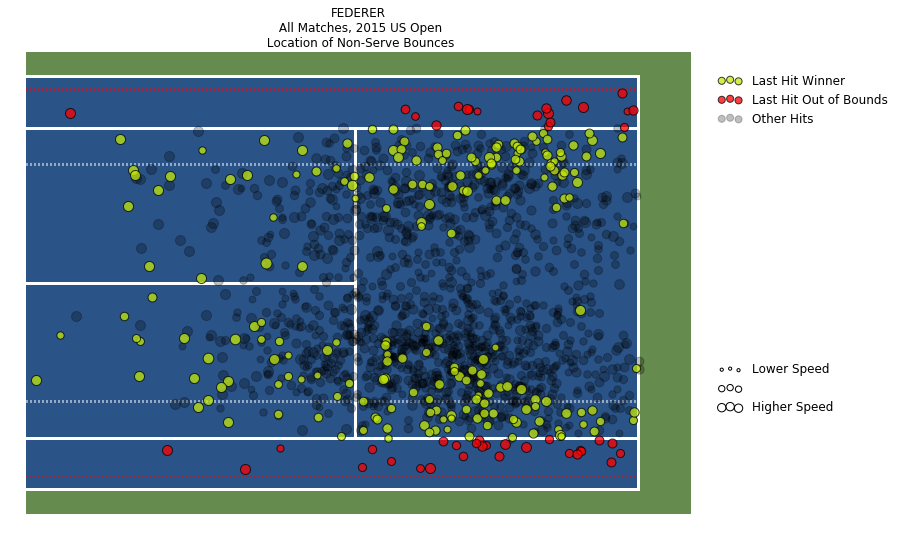

In [12]:
MatchCode = 'ALL'

if MatchCode != 'ALL':
    MatchLH = LastHitMain[LastHitMain['matchCode'] == MatchCode]
    OH = AllHitMain[AllHitMain['matchCode'] == MatchCode]
    plyrs = AllHits['playerName'][AllHits['matchCode'] == MatchCode].unique()
    opp = plyrs[plyrs != MainPlayer][0]
else:
    MatchLH = LastHitMain
    OH = AllHitMain
    
WLH = MatchLH[MatchLH['WonPoint'] == 1]
WLH = WLH[abs(WLH['Y']) <= Y]
WLH = WLH.reset_index(drop=True)
xWLH = WLH['X']; yWLH = WLH['Y']; sWLH = WLH['speed']

LLH = MatchLH[MatchLH['WonPoint'] == 0]
LLH = LLH[abs(LLH['Y']) > Y]
LLH = LLH[abs(LLH['Y']) <= Y + outline]
LLH = LLH.reset_index(drop=True)
xLLH = LLH['X']; yLLH = LLH['Y']; sLLH = LLH['speed']

OH = OH[OH['LastShot'] == 0]
OH = OH[abs(OH['Y']) <= Y]
OH = OH.reset_index(drop=True)
xOH = OH['X']; yOH = OH['Y']; sOH = OH['speed']

totwin= len(yWLH)
othside = len(yOH[abs(yOH) >= Y-inline]); roth = len(yOH[yOH < -Y+inline]); loth = len(yOH[yOH > Y-inline])
sidewin = len(yWLH[abs(yWLH) >= Y-inline]); rsidewin = len(yWLH[yWLH < -Y+inline]); lsidewin = len(yWLH[yWLH > Y-inline])
midwin = len(yWLH[abs(yWLH) < Y-inline])
nearmiss = len(yLLH); rnearmiss = len(yLLH[yLLH < 0]); lnearmiss = len(yLLH[yLLH > 0])
Totshots = len(xOH) + len(xWLH) + nearmiss

if MatchCode != 'ALL':
    print MainPlayer+' - '+MatchCode+' vs '+opp
else:
    print MainPlayer+' All Matches'
# print 'Number of Middle Court Winners = '+str(midwin)+' --- Pct of Winners = '+str(round(midwin/float(totwin),2))
print 'Number of Sideline Boundary Winners = '+str(sidewin)+' --- Pct of Winners = '+str(round(sidewin/float(totwin),4))
print 'Number of Other Hits Within Sideline Boundary = '+str(othside)
print 'Number of Sideline Near Misses = '+str(nearmiss)
print 'Total Number of Shots Within Sideline Boundary = '+str(sidewin+nearmiss+othside)+' --- Pct of Total Shots = '+str(round((nearmiss+sidewin+othside)/float(Totshots),4))
print 'Sideline Accuracy = '+str(round((othside+sidewin)/float(sidewin+nearmiss+othside),4))
print 'Left Sideline Accuracy = '+str(round((loth+lsidewin)/float(lsidewin+lnearmiss+loth),4))
print 'Right Sideline Accuracy = '+str(round((roth+rsidewin)/float(rsidewin+rnearmiss+roth),4))

fig8 = plt.figure(8,figsize=(X/1,2*Y/1))
plt.xlim(0,X+Xincr)
plt.ylim(-Y-Yincr,Y+Yincr)
CourtSurf()

for i in range(len(xWLH)):
    plt.scatter(xWLH[i],yWLH[i],facecolors='#C3E90A',edgecolors='k',alpha=.75,s=sWLH[i],zorder=7)

for i in range(len(xLLH)):
    plt.scatter(xLLH[i],yLLH[i],facecolors='r',edgecolors='k',alpha=.75,s=sLLH[i],zorder=7)
    
for i in range(len(xOH)):
    plt.scatter(xOH[i],yOH[i],facecolors='k',edgecolors='k',alpha=.25,s=sOH[i],zorder=6)

ycirc = plt.scatter([],[],facecolors='#C3E90A',edgecolors='k',alpha=.75,s=50)
rcirc = plt.scatter([],[],facecolors='r',edgecolors='k',alpha=.75,s=50)
kcirc = plt.scatter([],[],facecolors='k',edgecolors='k',alpha=.25,s=50)
ecirc = plt.scatter([],[],facecolors='none',edgecolors='k',s=10)
ecirc1 = plt.scatter([],[],facecolors='none',edgecolors='k',s=40)
ecirc2 = plt.scatter([],[],facecolors='none',edgecolors='k',s=70)

legend1 = plt.legend([ecirc,ecirc1,ecirc2],["Lower Speed", "", "Higher Speed"], loc=2,bbox_to_anchor=(1.025,.35),frameon=False)
plt.legend([ycirc,rcirc,kcirc],['Last Hit Winner','Last Hit Out of Bounds','Other Hits'],loc=2,bbox_to_anchor=(1.025,.975),frameon=False)
plt.gca().add_artist(legend1)

plt.axis('off')

if MatchCode != 'ALL':
    plt.title(MainPlayer+'\n Match '+MatchCode+" vs "+opp+"\n Location of Non-Serve Bounces")
else:
    plt.title(MainPlayer+'\n All Matches, 2015 US Open'+"\n Location of Non-Serve Bounces")
    
CourtLines()
plt.plot(np.linspace(0,Xmid,100),np.linspace(Y-inline,Y-inline,100),color='w',linestyle=':',linewidth=3)
plt.plot(np.linspace(0,Xmid,100),np.linspace(-Y+inline,-Y+inline,100),color='w',linestyle=':',linewidth=3)
plt.plot(np.linspace(0,Xmid,100),np.linspace(Y+outline,Y+outline,100),color='r',linestyle=':',linewidth=3)
plt.plot(np.linspace(0,Xmid,100),np.linspace(-Y-outline,-Y-outline,100),color='r',linestyle=':',linewidth=3)
plt.show()